In [1]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.8 MB/s eta 0:00:00


In [3]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import librosa
from PIL import Image

In [49]:
# dataloader arguments
batch_size = 32
data_path='audioMNIST_1'
#data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [51]:
def audio_to_image(y, sr):
    if len(y)<=16000:
      y = np.pad(y, (0,16000-len(y)), constant_values=(0,0))
    else:
      y = y[:16000]

    M = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=sr/2, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    for i in range(len(M_db)):
      for j in range(len(M_db[i])):
        if M_db[i][j] < -30:
          M_db[i][j] = 0
        else:
          M_db[i][j]+=80
    PIL_image = Image.fromarray(np.uint8(M_db))
    return PIL_image

In [71]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: Directory with all the label subdirectories
        transform: Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Read the directory and get the data paths and labels
        for sub in os.listdir(self.root_dir):
            subdir = os.path.join(self.root_dir, sub)
            for file_name in os.listdir(subdir):
                #Label is first character of file_name names '0' to '9'
                try:
                  label = int(file_name[0])
                  self.samples.append((os.path.join(subdir, file_name), label))
                except Exception:
                  continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        # Load the audio file
        raw_audio, sr = librosa.load(audio_path)
        # Convert audio to image
        image = audio_to_image(raw_audio, sr)
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
            transforms.Resize((256, 32)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Instantiate your dataset class with the root directory path and the transform
root_dir = 'audioMNIST_1'
audio_dataset = AudioDataset(root_dir=root_dir, transform=transform)

# Define the size of your test set
test_size = (int(0.2 * len(audio_dataset)))
train_size = (len(audio_dataset) - test_size)

# Split your dataset
M_train_dataset, M_test_dataset = random_split(audio_dataset, [train_size, test_size])
train_dataset = torch.utils.data.Subset(M_train_dataset, range(1600))
test_dataset = torch.utils.data.Subset(M_test_dataset, range(400))

# Create dataloaders for both the training set and the test set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [53]:
# Network Architecture
num_inputs = 256*32
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [72]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [73]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [74]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [75]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [76]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(data.shape)


torch.Size([32, 1, 256, 32])


label = 1


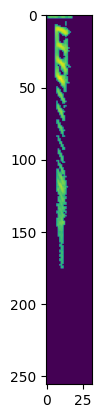

In [77]:
plt.imshow(data[1][0].cpu())
print(f'label = {int(targets[0])}')

In [78]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

In [79]:
print(f"Training loss: {loss_val.item():.3f}")

Training loss: 58.660


In [80]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 0.00%


In [81]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [82]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

In [83]:
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 49.728
Train set accuracy for a single minibatch: 62.50%


In [84]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            #if iter_counter == 0:
            #    train_printer()
            counter += 1
            iter_counter +=1
    counter-=1
    iter_counter-=1
    train_printer()
    counter+=1

Epoch 0, Iteration 49
Train Set Loss: 19.49
Test Set Loss: 21.63
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 75.00%


Epoch 1, Iteration 49
Train Set Loss: 4.31
Test Set Loss: 13.25
Train set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 62.50%


Epoch 2, Iteration 49
Train Set Loss: 5.64
Test Set Loss: 7.96
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 78.12%


Epoch 3, Iteration 49
Train Set Loss: 3.58
Test Set Loss: 13.52
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 75.00%


Epoch 4, Iteration 49
Train Set Loss: 3.42
Test Set Loss: 12.69
Train set accuracy for a single minibatch: 84.38%
Test set accuracy for a single minibatch: 68.75%


Epoch 5, Iteration 49
Train Set Loss: 2.58
Test Set Loss: 9.78
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 68.75%


Epoch 6, It

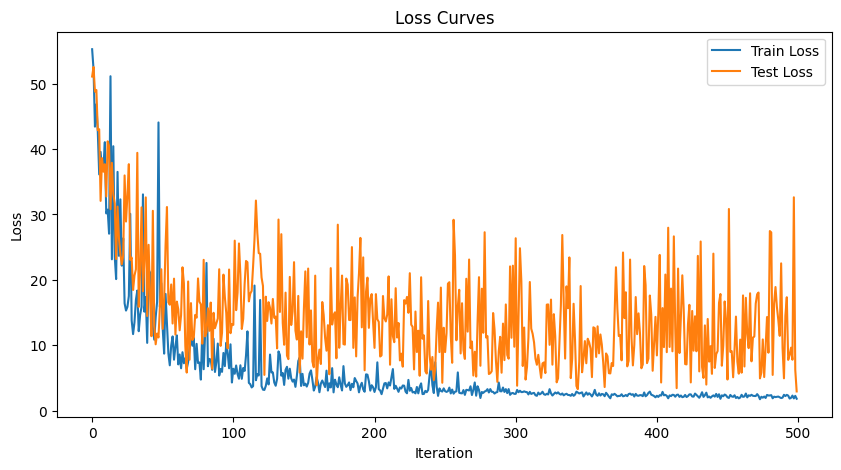

In [85]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [86]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 326/400
Test Set Accuracy: 81.50%
